In [4]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from google.colab import drive
import torch
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tqdm

# Preliminary Analysis of Features

Loading the data

In [2]:
def getfile(location_pair,**kwargs): #tries to get local version and then defaults to google drive version
    (loc,gdrive)=location_pair
    try:
        out=pd.read_csv(loc,**kwargs)
    except FileNotFoundError:
        print("local file not found; accessing Google Drive")
        loc = 'https://drive.google.com/uc?export=download&id='+gdrive.split('/')[-2]
        out= pd.read_csv(loc,**kwargs)
    return out

import urllib
def getLargeFile(location_pair,**kwargs): #tries to get local version and then defaults to google drive version
    (loc,gdrive)=location_pair
    try:
        out=pd.read_csv(loc,**kwargs)
    except FileNotFoundError:
        print("local file not found; accessing Google Drive")
        url = gdrive
        urllib.request.urlretrieve(gdrive, loc)
        out= pd.read_csv(loc,**kwargs)
    return out

fname = ("Crime_Data_from_2020_to_Present.csv", 
         "https://drive.google.com/u/0/uc?id=1WwLkX_BADtPY83rFQ4CQ5Lbf6UcI055A&export=download&confirm=t&uuid=4e0aae58-2f5b-4420-941f-8f2f49ae0cb8&at=ALAFpqzX_FrSz-hUtqhaXe2ui7h6:1667673013562")
df = getLargeFile(fname)
df.head()

local file not found; accessing Google Drive


,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
0,10304468,01/08/2020 12:00:00 AM,01/08/2020 12:00:00 AM,2230,3,Southwest,377,2,624,BATTERY - SIMPLE ASSAULT,...,AO,Adult Other,624.0,NaN,NaN,NaN,1100 W 39TH PL,NaN,34.0141,-118.2978
1,190101086,01/02/2020 12:00:00 AM,01/01/2020 12:00:00 AM,330,1,Central,163,2,624,BATTERY - SIMPLE ASSAULT,...,IC,Invest Cont,624.0,NaN,NaN,NaN,700 S HILL ST,NaN,34.0459,-118.2545
2,200110444,04/14/2020 12:00:00 AM,02/13/2020 12:00:00 AM,1200,1,Central,155,2,845,SEX OFFENDER REGISTRANT OUT OF COMPLIANCE,...,AA,Adult Arrest,845.0,NaN,NaN,NaN,200 E 6TH ST,NaN,34.0448,-118.2474
3,191501505,01/01/2020 12:00:00 AM,01/01/2020 12:00:00 AM,1730,15,N Hollywood,1543,2,745,VANDALISM - MISDEAMEANOR ($399 OR UNDER),...,IC,Invest Cont,745.0,998.0,NaN,NaN,5400 CORTEEN PL,NaN,34.1685,-118.4019
4,191921269,01/01/2020 12:00:00 AM,01/01/2020 12:00:00 AM,415,19,Mission,1998,2,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",...,IC,Invest Cont,740.0,NaN,NaN,NaN,14400 TITUS ST,NaN,34.2198,-118.4468


In [3]:
df.columns

Index(['DR_NO', 'Date Rptd', 'DATE OCC', 'TIME OCC', 'AREA', 'AREA NAME',
       'Rpt Dist No', 'Part 1-2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes',
       'Vict Age', 'Vict Sex', 'Vict Descent', 'Premis Cd', 'Premis Desc',
       'Weapon Used Cd', 'Weapon Desc', 'Status', 'Status Desc', 'Crm Cd 1',
       'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4', 'LOCATION', 'Cross Street', 'LAT',
       'LON'],
      dtype='object')

In [5]:
for column in df.columns.values:
    print(f'{column} with {df[column].unique().shape[0]} unique values')

DR_NO with 590832 unique values
Date Rptd with 1028 unique values
DATE OCC with 1028 unique values
TIME OCC with 1439 unique values
AREA with 21 unique values
AREA NAME with 21 unique values
Rpt Dist No with 1189 unique values
Part 1-2 with 2 unique values
Crm Cd with 137 unique values
Crm Cd Desc with 137 unique values
Mocodes with 208301 unique values
Vict Age with 101 unique values
Vict Sex with 5 unique values
Vict Descent with 20 unique values
Premis Cd with 310 unique values
Premis Desc with 307 unique values
Weapon Used Cd with 79 unique values
Weapon Desc with 79 unique values
Status with 5 unique values
Status Desc with 5 unique values
Crm Cd 1 with 140 unique values
Crm Cd 2 with 121 unique values
Crm Cd 3 with 36 unique values
Crm Cd 4 with 7 unique values
LOCATION with 59096 unique values
Cross Street with 8687 unique values
LAT with 5352 unique values
LON with 4949 unique values


## Consolidating and Examining the Dates of Crimes

We first convert the dates to datetime objects, shown below

In [6]:
df['Date Rptd'] = df['Date Rptd'].apply(lambda x: dt.datetime.strptime(x, "%m/%d/%Y %H:%M:%S %p").date())
df['DATE OCC'] = df['DATE OCC'].apply(lambda x: dt.datetime.strptime(x, "%m/%d/%Y %H:%M:%S %p").date())
df['Date Rptd'] = pd.to_datetime(df['Date Rptd'])
df['DATE OCC'] = pd.to_datetime(df['DATE OCC'])

We can take a look at which days of the week most crimes occurred

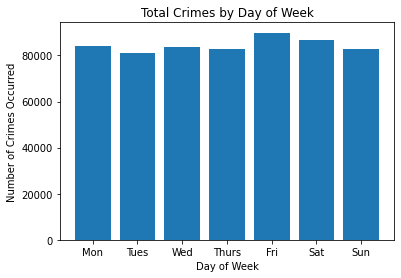

In [7]:
plt.bar(df['DATE OCC'].dt.day_of_week.value_counts().sort_index().index, df['DATE OCC'].dt.day_of_week.value_counts().sort_index())
plt.xticks(ticks = df['DATE OCC'].dt.day_of_week.value_counts().sort_index().index, labels = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
plt.xlabel('Day of Week')
plt.ylabel('Number of Crimes Occurred')
plt.title('Total Crimes by Day of Week')
plt.show()
plt.close()

Shown above, most crimes take place during the start of the weekend

We can also take a look at which months most crimes occurred

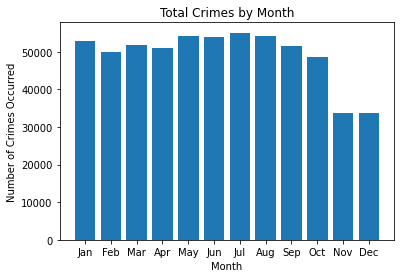

In [8]:
plt.bar(df['DATE OCC'].dt.month.value_counts().sort_index().index, df['DATE OCC'].dt.month.value_counts().sort_index())
plt.xticks(ticks = df['DATE OCC'].dt.month.value_counts().sort_index().index, \
    labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.title('Total Crimes by Month')
plt.xlabel('Month')
plt.ylabel('Number of Crimes Occurred')
plt.show()
plt.close()

Evidently, crime occurs more over the summer and the start of the year

## Examining Crime Categories

We can look at the top 10 crime categories

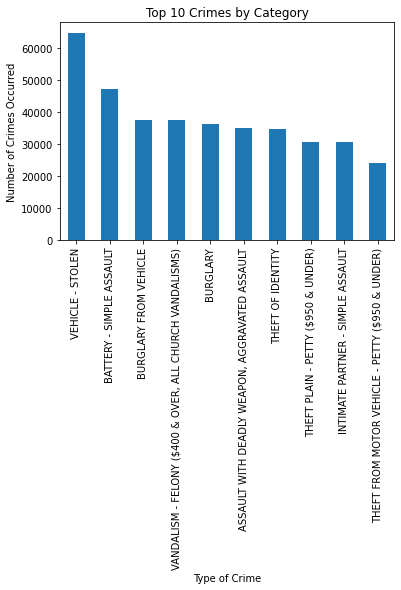

In [9]:
df['Crm Cd Desc'].value_counts()[:10].plot(kind = 'bar')
plt.xlabel('Type of Crime')
plt.ylabel('Number of Crimes Occurred')
plt.title('Top 10 Crimes by Category')
plt.show()
plt.close()

## Crime Evolution Over Time

Since the ultimate task of this project involves a Recurrent Neural Network with a time component, it is in our interest to obtain a preliminary idea of how crime evolves over time

### Total Crimes Over Time

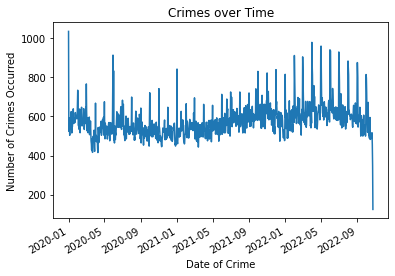

In [10]:
plt.plot(df['DATE OCC'].value_counts().sort_index().index, df['DATE OCC'].value_counts().sort_index())
plt.xlabel('Date of Crime')
plt.ylabel('Number of Crimes Occurred')
plt.title('Crimes over Time')
plt.gcf().autofmt_xdate()
plt.show()
plt.close()

### Crimes Occurred over Years, Grouped by Month

We must first format the data such that it can be used

In [11]:
df['Month OCC'] = df['DATE OCC'].dt.month
df['Year OCC'] = df['DATE OCC'].dt.year
month_year_occ = [str(m)+"/"+str(y) for m,y in zip(df["Month OCC"], df["Year OCC"])]
month_year_occ_formatted = [dt.datetime.strptime(d, "%m/%Y") for d in month_year_occ]
df["Month Year OCC"] = np.array(month_year_occ_formatted)

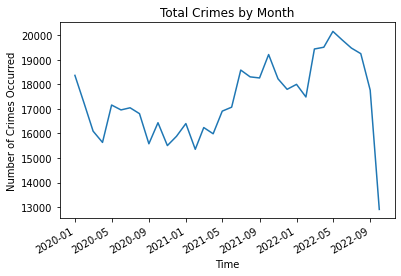

In [12]:
plt.plot(df["Month Year OCC"].value_counts().sort_index().index, df["Month Year OCC"].value_counts().sort_index())
plt.gcf().autofmt_xdate()
plt.title('Total Crimes by Month')
plt.xlabel('Time')
plt.ylabel('Number of Crimes Occurred')
plt.show()
plt.close()

### Crimes by Time of Day

We first define a few functions to read the military time format

In [13]:
# convert into 4-char strings
def makemil(time):
    ntime = ""
    if len(str(time)) == 1:
        ntime = "000" + str(time)
    if len(str(time)) == 2:
        ntime = "00" + str(time)
    if len(str(time)) == 3:
        ntime = "0" + str(time)
    if len(str(time)) == 4:
        ntime = str(time)
    return ntime

# function for retrieving the hour of the time
def returnhour(miltime):
    return miltime[:2]

In [14]:
df["TIME OCC"] = df["TIME OCC"].apply(makemil)

Plotting the number of crimes by time of day

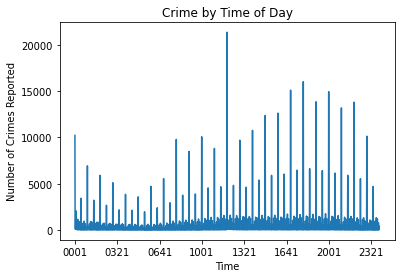

In [15]:
df['TIME OCC'].value_counts().apply(int).sort_index().plot()
plt.xlabel('Time')
plt.ylabel('Number of Crimes Reported')
plt.title('Crime by Time of Day')
plt.show()
plt.close()

We see that most crimes occur around midnight, which will be a key observation for our RNN

### Crimes by the Hour

In [16]:
df['Hour OCC'] =  df["TIME OCC"].apply(returnhour)

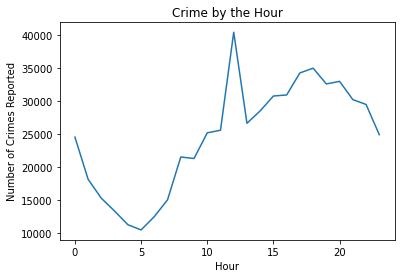

In [17]:
df['Hour OCC'].apply(int).value_counts().apply(int).sort_index().plot()
plt.xlabel('Hour')
plt.ylabel('Number of Crimes Reported')
plt.title('Crime by the Hour')
plt.show()
plt.close()

Plotting the number of crimes reported against the hour of the day confirms our hypothesis above

### Dropping Unnecessary Columns

In [18]:
# df.drop(columns = 'DR_NO', inplace = True) # DR number is all unique

# should we drop date rpt as well as we are solely intrested in the occurence of crimes?

## Deep Learning Method - RNN Model

### Model

* To explore the self-exciting property of crime number, we will use a RNN model to take the previous monthly data and predict the next time point's crime count, for a certain location and people with certain sex.

* Loss Function

Mean square error is applied for loss function.

$$\mathcal{L}(Y, Y') = \frac{1}{\|\mathcal{D_{train}}\|} \sum_{y\in Y}(y - y')^2$$



In [122]:
class RNNModel(torch.nn.Module):
  def __init__(self, input_dims, hidden_dims, gru_layers = 2, dropout_rate = 0.3, device = None):
    super(RNNModel, self).__init__()
    # encoder
    self.fc1 = torch.nn.Linear(input_dims, hidden_dims)
    # rnn
    self.gru = torch.nn.GRU(hidden_dims, hidden_dims, num_layers=gru_layers, dropout = dropout_rate)
    # decoder
    self.fc2 = torch.nn.Linear(hidden_dims, hidden_dims)
    self.fc3 = torch.nn.Linear(hidden_dims, 1)

    self.loss_fn = torch.nn.MSELoss()
    self.opt = None

    self.gru_layers = gru_layers
    self.hidden_dims = hidden_dims

    self.device = device if device is not None else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  
  def forward(self, x, h):
    x = self.fc1(x)
    x = torch.sigmoid(x)

    x, h_next = self.gru(x, h)

    x = self.fc2(x)
    x = torch.tanh(x)

    x = self.fc3(x).squeeze(dim=-1)
    x = torch.relu(x)
    return x, h_next
  
  def metrics(self, y_pred, y):
    return torch.mean(torch.abs(y - y_pred)).cpu().detach().numpy()

  def prepare_data_into_batches(self, dataset, keys):
    out_data = {}
    for key in keys:
      data = dataset[key]["data"]
      label = dataset[key]["label"]
      length = data.shape[0]
      feature_num = data.shape[1]
      if length not in out_data:
        out_data[length] = {"data": [], "label":[]}
      out_data[length]["data"].append(torch.Tensor(data).to(torch.float32).to(self.device).view(length, 1, feature_num))
      out_data[length]["label"].append(torch.Tensor(label).to(torch.float32).to(self.device).view(length, 1))
    out_x = []
    out_y = []
    for length in out_data:
      out_x.append(torch.cat(out_data[length]['data'], dim=1))
      out_y.append(torch.cat(out_data[length]['label'], dim=1))
    
    return out_x, out_y
    
  def train_model(self, dataset, keys, num_epoch = 10, learning_rate = 1e-3, optimizer_type=torch.optim.SGD):
    if self.opt is None:
      self.opt = optimizer_type(self.parameters(), lr=learning_rate)

    tensor_x, tensor_y = self.prepare_data_into_batches(dataset, keys)

    losses = []
    self.train()
    
    for e in range(num_epoch+1):
      losses_epoch = []
      for (x, y) in zip(tensor_x, tensor_y):
        h0 = torch.zeros([self.gru_layers, x.shape[1], self.hidden_dims]).to(torch.float32).to(self.device)

        pred, h_n = self.forward(x, h0)
        loss = self.loss_fn(pred, y)

        self.opt.zero_grad()
        loss.backward()
        self.opt.step()

        losses_epoch.append(loss.cpu().detach().numpy())
      losses.append(np.mean(losses_epoch))
      if e % (num_epoch // 10) == 0:
        print(f"Epoch {e:02d}: loss - {losses[-1]:.5f}")
      
    return losses

  def test(self, dataset, keys):
    tensor_x, tensor_y = self.prepare_data_into_batches(dataset, keys)

    metric = 0
    num_data = 0
    self.eval()
    
    with torch.no_grad():
      losses_epoch = []
      for (x, y) in zip(tensor_x, tensor_y):
        h0 = torch.zeros([self.gru_layers, x.shape[1], self.hidden_dims]).to(torch.float32).to(self.device)

        pred, h_n = self.forward(x, h0)

        metric_batch = self.metrics(pred, y)
        metric += metric_batch * pred.shape[0] * pred.shape[1]
        num_data += pred.shape[0] * pred.shape[1] 

    return metric / num_data

### Problem  Description

* Purpose: From the initial analysis, we find that `Month/Year`, `Latitude/Longitude`, and `Victim Sex` are some of important features that affects the number of crimes. To find if crime count is self-exciting, we want to predict future crime count given previous crime data by RNN model.
* Features:
  * Scalar Features:
    * Latitude
    * Longitude

  * Categorical Features:
    * Victim Sex (F, M, X, H)
    * Month (1 to 12)
    * Year (2020, 2021, 2022)

* Target: Given previous crime records for a certain location (`Lat` + `Lon`) and victim sex, predict **the number of crimes** for the next time point.

In [34]:
class Utils:
  def __init__(self):
    pass

  @classmethod
  def one_hot_encoding(cls, categories, data) -> np.ndarray:
    """
    Args:
      categories: [Nc, ]
      data: [N, ]
    Returns:
      result: [N, Nc]
    """
    sorted_categories = sorted(categories)

    category_map = {c: i for i, c in enumerate(sorted_categories)}

    ids = np.array(list(map(lambda c: category_map[c], data)))
   
    result = np.zeros((data.shape[0], len(categories)))

    result[np.arange(ids.size), ids] = 1

    return result


### Dataset Preparation

* Group the dataset by feature set, get the number of crimes for each group

In [35]:
df['Count'] = np.ones(df.shape[0])
df.head(5)

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Crm Cd 4,LOCATION,Cross Street,LAT,LON,Month OCC,Year OCC,Month Year OCC,Hour OCC,Count
0,10304468,2020-01-08,2020-01-08,2230,3,Southwest,377,2,624,BATTERY - SIMPLE ASSAULT,...,NaN,1100 W 39TH PL,NaN,34.0141,-118.2978,1,2020,2020-01-01,22,1.0
1,190101086,2020-01-02,2020-01-01,0330,1,Central,163,2,624,BATTERY - SIMPLE ASSAULT,...,NaN,700 S HILL ST,NaN,34.0459,-118.2545,1,2020,2020-01-01,03,1.0
2,200110444,2020-04-14,2020-02-13,1200,1,Central,155,2,845,SEX OFFENDER REGISTRANT OUT OF COMPLIANCE,...,NaN,200 E 6TH ST,NaN,34.0448,-118.2474,2,2020,2020-02-01,12,1.0
3,191501505,2020-01-01,2020-01-01,1730,15,N Hollywood,1543,2,745,VANDALISM - MISDEAMEANOR ($399 OR UNDER),...,NaN,5400 CORTEEN PL,NaN,34.1685,-118.4019,1,2020,2020-01-01,17,1.0
4,191921269,2020-01-01,2020-01-01,0415,19,Mission,1998,2,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",...,NaN,14400 TITUS ST,NaN,34.2198,-118.4468,1,2020,2020-01-01,04,1.0


In [61]:
scalar_features = ['LAT', 'LON']
categorical_features = ['Year OCC', 'Month OCC', 'Vict Sex']
target_feature = ['Count']
source_features = scalar_features + categorical_features
all_features = source_features + target_feature

data = df[all_features].copy()
data = data.dropna()
data['LAT'] = data['LAT'].apply(lambda x: np.round(x, 2))
data['LON'] = data['LON'].apply(lambda x: np.round(x, 2))

data = data[(data.T != 0).all()]

In [64]:
dataset = data.groupby(source_features).agg('sum').reset_index()
dataset = dataset.dropna()
print(f"Dataset size: {dataset.shape}")
dataset.head(5)

Dataset size: (79032, 6)


,LAT,LON,Year OCC,Month OCC,Vict Sex,Count
0,33.71,-118.31,2020,2,M,1.0
1,33.71,-118.31,2020,2,X,1.0
2,33.71,-118.31,2020,5,F,1.0
3,33.71,-118.31,2020,6,F,1.0
4,33.71,-118.31,2020,11,F,1.0


In [68]:
# grouping data for (lat, lng, sex)
group_features_sex = ['LAT', 'LON', 'Vict Sex']
gb_sex = dataset.groupby(group_features_sex)
print(f"Total number of groups for (lat, lon, sex): {len(gb_sex.groups)}")

group_data = {}
for x in gb_sex.groups:
  data = gb_sex.get_group(x)
  if len(data) >= 5:
    group_data[x] = data
print(f"Total number of valid groups for (lat, lon, sex): {len(group_data)}")

Total number of groups for (lat, lon, sex): 3610
Total number of valid groups for (lat, lon, sex): 3019


* Data preprocessing:
  * scalar feature: normalization
$$x_{norm} = \frac{x-\mu_x}{\sigma_x}$$
  * categorical feature: one-hot embedding

In [87]:
dataset_processed = {}
# scalar features:
scalar_data = dataset[scalar_features].to_numpy()
scalar_mean = scalar_data.mean(axis=0)
scalar_std = scalar_data.std(axis=0)
# categorial features:
categories = { c: dataset[c].unique() for c in categorical_features }


for key in group_data:
  dataset_key = group_data[key]
  # Encoding dataset
  dataset_enc = []
  feature_end_ids = []
  scalar_data = dataset_key[scalar_features].to_numpy()
  scalar_norm = (scalar_data - scalar_mean) / scalar_std
  dataset_enc.append(scalar_norm)
  feature_end_ids.extend((np.arange(len(scalar_features)) + 1).tolist())

  for c in categorical_features:
    dataset_enc.append(Utils.one_hot_encoding(categories[c], dataset_key[c].to_numpy()))
    if len(feature_end_ids) > 0:
      feature_end_ids.append(feature_end_ids[-1] + len(categories[c]))
    else:
      feature_end_ids.append([len(categories[c])])

  dataset_enc = np.concatenate(dataset_enc, axis=1)

  labels = dataset_key[target_feature].to_numpy().flatten()

  dataset_processed[key] = {'data': dataset_enc, "label": labels}

print(len(dataset_processed))

3019


### Model Training & Testing

* Train/Test Split
  * Training size: 60%
  * Validation size: 20%
  * Testing size: 20%

In [135]:
num_rows, num_features = dataset_enc.shape

random_seed = 0
torch.manual_seed(random_seed)
np.random.seed(random_seed)

test_size = 0.2
validation_size = 0.2

num_epoch = 1000
learning_rate = .01

In [124]:
keys = list(dataset_processed.keys())
num_keys = len(keys)

num_test = round(num_keys * test_size)
num_val = round(num_keys * validation_size)
num_train = num_keys - num_test - num_val

print(num_train, num_val, num_test)

1811 604 604


In [125]:
np.random.seed(random_seed)
np.random.shuffle(keys)

In [126]:
train_keys = keys[:num_train]
test_keys = keys[num_train:num_train+num_test]
val_keys = keys[-num_val:]
print(val_keys[:3])

[(34.02, -118.32, 'M'), (33.97, -118.28, 'X'), (34.16, -118.53, 'M')]


* Training with default settings

In [140]:
in_dims = dataset_processed[train_keys[0]]['data'].shape[1]

In [136]:
# train benchmark
torch.manual_seed(random_seed)
model_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
rnn_model = RNNModel(input_dims=in_dims, hidden_dims=8, dropout_rate=0.0)
rnn_model.to(model_device)
losses = rnn_model.train_model(
    dataset_processed, train_keys, num_epoch=num_epoch, learning_rate=learning_rate)

Epoch 00: loss - 11.02808
Epoch 100: loss - 9.48305
Epoch 200: loss - 9.23532
Epoch 300: loss - 8.91191
Epoch 400: loss - 8.94074
Epoch 500: loss - 8.72316
Epoch 600: loss - 8.43702
Epoch 700: loss - 8.56459
Epoch 800: loss - 7.80883
Epoch 900: loss - 7.39976
Epoch 1000: loss - 8.65513


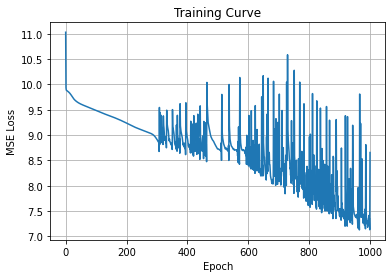

In [137]:
plt.clf()
plt.plot(np.arange(len(losses)), losses)
plt.title("Training Curve")
plt.ylabel("MSE Loss")
plt.xlabel("Epoch")
plt.grid()
plt.show()
plt.close()

* Testing

In [139]:
rnn_model.to(rnn_model.device)
metric = rnn_model.test(dataset_processed, test_keys)
print(f"Final metrics of rnn model = {metric:.5f}")

Final metrics of rnn model = 3.62832


### Effects of different optimizers

All optimizer use the same initial learning rate.

In [142]:
optimizer_types = {"SGD": torch.optim.SGD, "Adam": torch.optim.Adam, "RMSprop": torch.optim.RMSprop}

In [143]:
losses = []
metrics = []
models = []

for (optimizer_type, optimizer_class) in optimizer_types.items():
  torch.manual_seed(random_seed)
  rnn_model_c = RNNModel(input_dims=in_dims, hidden_dims=8)
  rnn_model_c.to(rnn_model_c.device)
  losses_c = rnn_model_c.train_model(
      dataset_processed, train_keys, num_epoch=num_epoch, 
      learning_rate=learning_rate, optimizer_type = optimizer_class)
  losses.append(losses_c)

  metric_c = rnn_model_c.test(dataset_processed, test_keys)
  metrics.append(metric_c)
  models.append(rnn_model_c)
np.savetxt("effect_optimizer_losses.npy", np.array(losses))
np.savetxt("effect_optimizer_metrics.npy", np.array(metrics))

Epoch 00: loss - 11.04305
Epoch 100: loss - 9.50785
Epoch 200: loss - 9.28613
Epoch 300: loss - 9.05253
Epoch 400: loss - 8.73172
Epoch 500: loss - 8.76305
Epoch 600: loss - 8.61204
Epoch 700: loss - 7.92163
Epoch 800: loss - 7.74200
Epoch 900: loss - 7.62613
Epoch 1000: loss - 7.47766
Epoch 00: loss - 11.20757
Epoch 100: loss - 8.98290
Epoch 200: loss - 7.30588
Epoch 300: loss - 6.79103
Epoch 400: loss - 6.70466
Epoch 500: loss - 6.29686
Epoch 600: loss - 6.05312
Epoch 700: loss - 5.91061
Epoch 800: loss - 6.17302
Epoch 900: loss - 5.28675
Epoch 1000: loss - 5.23895
Epoch 00: loss - 10.27487
Epoch 100: loss - 8.59652
Epoch 200: loss - 9.05483
Epoch 300: loss - 8.61305
Epoch 400: loss - 8.95111
Epoch 500: loss - 8.13206
Epoch 600: loss - 7.15704
Epoch 700: loss - 6.67695
Epoch 800: loss - 6.47777
Epoch 900: loss - 6.45693
Epoch 1000: loss - 5.96295


[0.32913819 0.30719107 0.30593919]


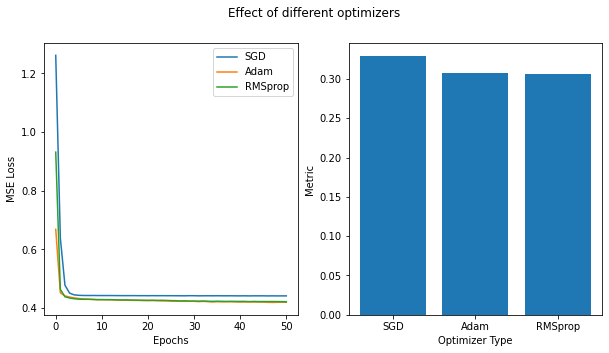

In [ ]:
# Plot the effect
losses = np.loadtxt("effect_optimizer_losses.npy")
metrics = np.loadtxt("effect_optimizer_metrics.npy")
epochs = np.arange(losses.shape[1])

print(metrics)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for (i, optimizer_type) in enumerate(optimizer_types):
  loss_data = losses[i]
  metric_data = metrics[i]
  axes[0].plot(epochs, loss_data, label=optimizer_type)

axes[0].legend()
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("MSE Loss")

xticks = np.arange(metrics.shape[0])
axes[1].bar(xticks, metrics)
axes[1].set_xticks(xticks)
axes[1].set_xticklabels(list(optimizer_types.keys()))
axes[1].set_xlabel("Optimizer Type")
axes[1].set_ylabel("Metric")
fig.suptitle("Effect of different optimizers")
plt.show()

### Hyperparameter Tuning (Training, Testing and Validation)

Given the fact above,`optimizer = RMSprop` are selected.

For hyperparameter tuning, choose Hidden layer dimensions from:  [4, 8, 16]

In [145]:
opt_optimizer = torch.optim.RMSprop

In [147]:
# Hidden Layer Dimensions

hidden_layer_dims = [4, 8, 16]

metrics = []
for hidden_layer_dim in hidden_layer_dims:
  rnn_model_c = RNNModel(input_dims=in_dims, hidden_dims=hidden_layer_dim)
  rnn_model_c.to(rnn_model_c.device)
  _ = rnn_model_c.train_model(
      dataset_processed, train_keys, num_epoch=num_epoch, 
      learning_rate=learning_rate, optimizer_type = opt_optimizer)

  metric_c = rnn_model_c.test(dataset_processed, val_keys)
  metrics.append(metric_c)

  print(metric_c)

print(f"Hidden Layer Dimensions: {hidden_layer_dims}")
print(f"Metrics on validation set: {metrics}")

opt_id = np.argmin(metrics)
opt_hidden_layer_dim = hidden_layer_dims[opt_id]
print(f"Optimal hidden layer dimension: {opt_hidden_layer_dim}")

Epoch 00: loss - 14.74250
Epoch 100: loss - 14.74250
Epoch 200: loss - 14.74250
Epoch 300: loss - 14.74250
Epoch 400: loss - 14.74250
Epoch 500: loss - 14.74250
Epoch 600: loss - 14.74250
Epoch 700: loss - 14.74250
Epoch 800: loss - 14.74250
Epoch 900: loss - 14.74250
Epoch 1000: loss - 14.74250
6.218291135137757
Epoch 00: loss - 10.38289
Epoch 100: loss - 8.33686
Epoch 200: loss - 7.75929
Epoch 300: loss - 7.52144
Epoch 400: loss - 6.90136
Epoch 500: loss - 6.89962
Epoch 600: loss - 6.58777
Epoch 700: loss - 5.92187
Epoch 800: loss - 5.58753
Epoch 900: loss - 5.38591
Epoch 1000: loss - 5.46993
3.4653061801066407
Epoch 00: loss - 14.74250
Epoch 100: loss - 14.74250
Epoch 200: loss - 14.74250
Epoch 300: loss - 14.74250
Epoch 400: loss - 14.74250
Epoch 500: loss - 14.74250
Epoch 600: loss - 14.74250
Epoch 700: loss - 14.74250
Epoch 800: loss - 14.74250
Epoch 900: loss - 14.74250
Epoch 1000: loss - 14.74250
6.218291135137757
Hidden Layer Dimensions: [4, 8, 16]
Metrics on validation set: [

### Train optimal model with optimal settings and test the model on test set

In [150]:
torch.manual_seed(random_seed)
opt_model = RNNModel(input_dims=in_dims, hidden_dims=opt_hidden_layer_dim)
opt_model.to(opt_model.device)
_ = opt_model.train_model(
    dataset_processed, train_keys + val_keys, num_epoch=num_epoch, 
    learning_rate=learning_rate, optimizer_type = opt_optimizer)

Epoch 00: loss - 9.40086
Epoch 100: loss - 7.66475
Epoch 200: loss - 7.38433
Epoch 300: loss - 7.54153
Epoch 400: loss - 6.95256
Epoch 500: loss - 6.26408
Epoch 600: loss - 6.22274
Epoch 700: loss - 5.66318
Epoch 800: loss - 5.60406
Epoch 900: loss - 5.34859
Epoch 1000: loss - 5.06374


In [151]:
metric = opt_model.test(dataset_processed, test_keys)
print(f"Optimal model metric: {metric:.5f} on test set")

Optimal model metric: 3.62832 on test set


## Conclusion

* The convergence of the RNN model tells that the crime data have self-exciting property along time for certain location, certain victim sex.